In [3]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import interpolate, optimize
import os

In [149]:
def get_model_measures(model, condition):
    sol = model.solve(condition)
    return condition['tta_condition'], condition['d_condition'], sol.prob_correct(), sol.mean_decision_time()
        
def plot_measures(exp_data, model_measures, model_name):   
    fig, ax = plt.subplots(1, 1)
    sns.pointplot(ax=ax, data=exp_data, x='tta_condition', y='is_turn_decision', hue='d_condition', 
                  markers=['o', 's', '^'])
    sns.pointplot(ax=ax, data=model_measures, x='tta_condition', y='is_turn_decision', hue='d_condition',
                  markers=['o', 's', '^'], color='k', dodge=True)
    ax.set_xlabel('TTA')
    ax.set_ylabel('p(turn)')
    ax.legend(loc='center left', bbox_to_anchor=(1, 0, 0.5, 1))
    ax.set_title('Model %s, WLS=%.5f' % (model_name.replace('_', ' ').title(), model_measures.loss[0]))
    sns.despine(offset=5, trim=True)
    
    fig, axes = plt.subplots(1, 3, figsize=(10,3), sharex=True, sharey=True)
    d_conditions = sorted(exp_data.d_condition.unique())
    for i, ax in enumerate(axes):
        sns.pointplot(kind='point', ax=ax, 
                      data=exp_data[exp_data.is_turn_decision & (exp_data.d_condition == d_conditions[i])], 
                      x='tta_condition', y='RT', hue='d_condition', markers=['o', 's', '^'])
        sns.pointplot(kind='point', ax=ax, data=model_measures[model_measures.d_condition == d_conditions[i]], 
                      x='tta_condition', y='RT', hue='d_condition', 
                      markers=['o', 's', '^'], color='k', dodge=True)
        ax.set_xlabel('TTA')
        ax.set_title('d=%.0fm' % d_conditions[i])
        ax.get_legend().remove()
    sns.despine(offset=5, trim=True)
        
    axes[2].legend(loc='center left', bbox_to_anchor=(1, 0, 0.5, 1))
    
def plot_rt_pdfs(exp_data, model_rts):
    fig, axes = plt.subplots(3, 3, figsize=(10,8), sharex=True, sharey=True)
    conditions = [(d, tta) 
                  for d in sorted(exp_data.d_condition.unique()) 
                  for tta in sorted(exp_data.tta_condition.unique())]
    for (ax, condition) in zip(axes.flatten(), conditions):
        model_hist = model_rts[(model_rts.d_condition==condition[0]) & (model_rts.tta_condition==condition[1])]
        exp_rts = exp_data[(exp_data.is_turn_decision) 
                            & (exp_data.d_condition==condition[0]) 
                            & (exp_data.tta_condition==condition[1])].RT
        if len(exp_rts) >= 10:
            ax.plot(model_hist.t, model_hist.rt_corr_pdf, label='Model')
            sns.distplot(a=exp_rts, ax=ax, label='Experiment', kde_kws={'clip': (0.0, exp_rts.max())})
        ax.set_xlabel('')
        ax.set_xlim((0, 2.5))
        ax.text(0.7, 0.8, 'N=%i' % len(exp_rts), fontsize=16, transform=ax.transAxes,  
                horizontalalignment='center', verticalalignment='center')
        
    for ax, d in zip(axes[0], sorted(exp_data.d_condition.unique())):
        ax.text(0.5, 0.99, 'd=%im' % d, fontsize=18, transform=ax.transAxes,
                horizontalalignment='center', verticalalignment='center')
        
    for ax, tta in zip(axes.T[2], sorted(exp_data.tta_condition.unique())):
        ax.text(0.99, 0.5, 'TTA=%is' % tta, fontsize=18, transform=ax.transAxes, rotation=-90, 
                horizontalalignment='center', verticalalignment='center')

    fig.text(0.5, 0.04, 'RT', fontsize=24)
    fig.text(0.04, 0.5, 'pdf', fontsize=24, rotation=90)
    
def visualize_model_fit(exp_data, model_name):
    model_results_path = os.path.join(fit_results_path, model_name)
    model_measures = pd.read_csv(os.path.join(model_results_path, 'measures.csv'))
    model_rts = pd.read_csv(os.path.join(model_results_path, 'rt_pdf.csv'))
    plot_measures(exp_data, model_measures, model_name)
    plot_rt_pdfs(exp_data, model_rts)    

In [122]:
exp_data = pd.read_csv('measures.csv', usecols=['RT', 'is_turn_decision', 'tta_condition', 'd_condition'])

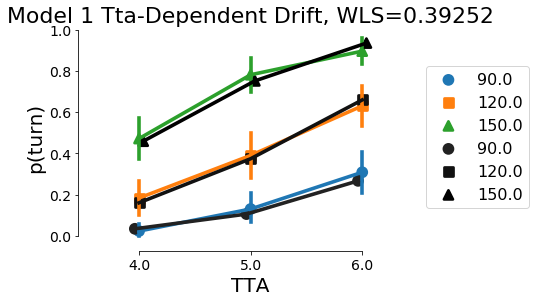

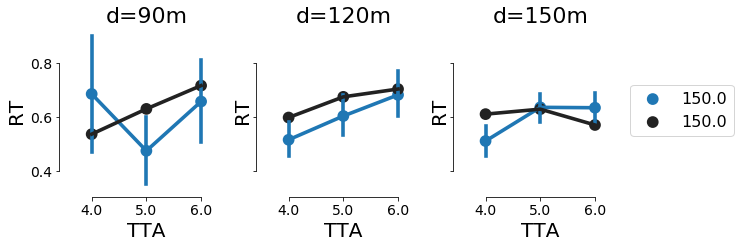

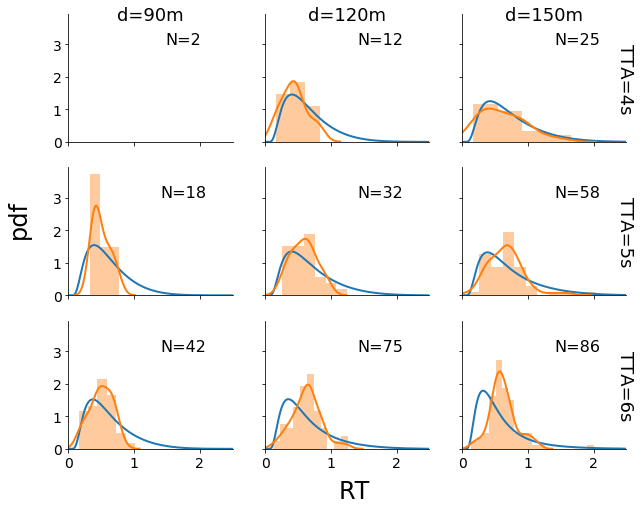

In [150]:
fit_results_path = 'model_fit_results/tta_and_d'
for model_name in os.listdir(fit_results_path):
    visualize_model_fit(exp_data, model_name)